In [1]:
import numpy as np
import pandas as pd
import mygene
import omnipath as op
import matplotlib.pyplot as plt
import seaborn as sns
import mellon as ml
import random
import networkx as nx

c:\Users\melis\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import gtex expression data

gtex_link = 'https://storage.googleapis.com/gtex_analysis_v7/rna_seq_data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct.gz'
exp = pd.read_csv(gtex_link, sep='\t', index_col='gene_id', skiprows=2)
exp_cns = exp.loc[:, ['Brain - Anterior cingulate cortex (BA24)',
       'Brain - Caudate (basal ganglia)', 'Brain - Cerebellar Hemisphere',
       'Brain - Cerebellum', 'Brain - Cortex', 'Brain - Frontal Cortex (BA9)',
       'Brain - Hippocampus', 'Brain - Hypothalamus',
       'Brain - Nucleus accumbens (basal ganglia)',
       'Brain - Putamen (basal ganglia)', 'Brain - Spinal cord (cervical c-1)',
       'Brain - Substantia nigra']]
exp_cns = exp_cns.loc[(exp_cns > 0).any(axis=1)]

# convert gtex gene names from ENSEMBL to gene symbols
mg = mygene.MyGeneInfo()
ensembl_gtex = list(np.unique(pd.DataFrame(list(exp_cns.index.str.split('.')))[0]))
symbols_gtex = mg.querymany(ensembl_gtex, scopes='ensembl.gene', fields='symbol', species='human')
symbols_gtex = pd.DataFrame(symbols_gtex)['symbol']

# import omnipath db
db = op.interactions.import_intercell_network(transmitter_params = {"categories":"ligand"}, receiver_params = {"categories": "receptor"})
db = db[np.logical_not(db['genesymbol_intercell_source'].str.startswith('HLA'))]
db = db[np.logical_not(db['genesymbol_intercell_target'].str.startswith('HLA'))]
db = db[~db['genesymbol_intercell_target'].astype(str).str.startswith('COMPLEX')]
db = db[~db['genesymbol_intercell_source'].astype(str).str.startswith('COMPLEX')]

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-32767...done.
Finished.
4 input query terms found dup hits:
	[('ENSG00000229425

In [3]:
brain_genes = symbols_gtex.rename('gene')
brain_genes.dropna(inplace = True)
all_source, pctsrc, all_targets, pcttgt, summary_LR = ml.lr.find_hits(pd.DataFrame(brain_genes.index, index = list(brain_genes)),db)
brainLR = pd.concat([all_source['gene'],all_targets['gene']], axis = 0).unique()


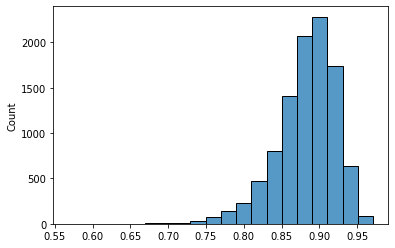

KeyboardInterrupt: 

In [20]:

reslist = [0.7, 0.4, 0.1]
iter = 10000

for res in range(0,len(reslist)):

    genes = pd.read_csv('processed_data/03-LR_network_visualisation/louvain_largest_cluster_%s.csv' % reslist[res])
    boot = []
    for i in range (0,iter):
            rand = random.sample(range(0,len(brainLR)), np.shape(genes)[0])
            brainSubset = pd.DataFrame(brainLR).iloc[rand]
            LRs = db[['genesymbol_intercell_source','genesymbol_intercell_target']][(db['genesymbol_intercell_source'].isin(list(brainSubset[0]))) | (db['genesymbol_intercell_target'].isin(list(brainSubset[0])))]
            LRs = LRs.dropna()
            unique_genes = list(pd.concat([LRs['genesymbol_intercell_source'],LRs['genesymbol_intercell_target']], axis = 0).unique())
            adj_LRs = pd.DataFrame(np.zeros(shape=(len(unique_genes), len(unique_genes))), index = unique_genes, columns = unique_genes)
            for n in range (0, np.shape(LRs)[0]):
                adj_LRs.iloc[adj_LRs.index.get_loc(LRs.iloc[n]['genesymbol_intercell_source']), adj_LRs.columns.get_loc(LRs.iloc[n]['genesymbol_intercell_target'])] += 1
            # Create network and detect communities
            H = nx.from_pandas_adjacency(adj_LRs)
            comms = ml.network.louvain_communities(H, seed = 123, resolution = 0.01)

            # Check which is the largest network and save % of total LRs in network
            for l in range(0,len(comms)):
                this = len(comms[l])
                
                if (l == 0):
                    longest = this
                    cluster = comms[l]
                elif (this > longest):
                    longest = this
                    cluster = comms[l]
                
            boot.append(longest/len(H))
            del adj_LRs
            del LRs

    sns.histplot(data = boot, bins = 20)
    plt.savefig('plots/03-LR_network_visualisation/03d_network_stats_per_threshold/hist_distribution_%s.png' % reslist[res], dpi=150)
    plt.show()

    if (res==0):
        results = pd.DataFrame(boot, columns = [reslist[res]])
    else: 
       results = pd.concat([results, pd.DataFrame(boot, columns = [reslist[res]])], axis = 1)

results.to_csv('processed_data/03-LR_network_visualisation/03d_network_stats_per_threshold/bootstrapped_results_10000iter_%majornetwork.csv')
            


In [29]:
(results[0.7]<0.656410256).sum()/10000

0.0004

In [30]:
(results[0.7]>0.656410256).sum()/10000

0.9996

In [31]:
(pd.DataFrame(boot)<0.96325167).sum()/10000

0    0.7174
dtype: float64

In [32]:
(pd.DataFrame(boot)>0.96325167).sum()/10000

0    0.0983
dtype: float64